In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from face_dataset import *
from glob import glob

In [2]:
groups = [os.path.basename(os.path.normpath(path_string)) for path_string in glob("./AI_Morphometrics/*/", recursive = False)]

In [29]:
groups = ['Turci']
results = {}
for j, group in tqdm(enumerate(groups)):
    print(group)
    try:
        results[group] = torch.zeros(200)
        model = FaceLandmarking().to(DEVICE)
        face_dataset = FaceDataset(model, subgroup=group)
        face_dataloader = DataLoader(face_dataset, batch_size=50, shuffle=True)
        optimizer1 = torch.optim.Adam(model.raw_projection.parameters(), lr = 0.0001)
        optimizer2 = torch.optim.Adam(model.cnn_focusing.parameters(), lr = 0.0001)
        optimizer3 = torch.optim.Adam(model.ffn.parameters(), lr = 0.0001)
        epochs = 200
        PRETRAINING = True
        pretrain_epochs = 500
        optimizers = [optimizer1]
        TRAIN_PHASE = 0

        for epoch in range(epochs):

            if epoch == pretrain_epochs:
                PRETRAINING = False
                optimizers = [optimizer2]
                TRAIN_PHASE += 1
                print('Freezing raw_projection, training CNN_focusing.')

            if epoch == 600:
                optimizers = [optimizer3]
                TRAIN_PHASE += 1
                print('Freezing CNN_focusing, training top FFN.')

            if epoch == 800:
                optimizers = [optimizer1, optimizer2, optimizer3]

            face_dataset.pretraining = PRETRAINING
            model.train_phase = TRAIN_PHASE

            for iteration, batch in enumerate(face_dataloader):
                for optimizer in optimizers:
                    optimizer.zero_grad()

                inputs, targets, centroid, size_measure, multicrop = batch
                _, final_loss, raw_loss = model(
                    inputs,
                    targets = targets,
                    centroid = centroid,
                    size_measure = size_measure,
                    multicrop = multicrop,
                )

                final_loss.backward()

                for optimizer in optimizers:
                    optimizer.step()

                results[group][epoch] = final_loss
    except Exception as e:
        print(e)

0it [00:00, ?it/s]

Turci


1it [00:18, 18.04s/it]


In [21]:
results = {}
mean = {}
std = {}
for group in tqdm(groups):
    try:
        model = FaceLandmarking().to(DEVICE)
        face_dataset = FaceDataset(model, subgroup=group)
        face_dataloader = DataLoader(face_dataset, batch_size=50, shuffle=True)
        optimizer1 = torch.optim.Adam(model.raw_projection.parameters(), lr = 0.0001)
        optimizer2 = torch.optim.Adam(model.cnn_focusing.parameters(), lr = 0.0001)
        optimizer3 = torch.optim.Adam(model.ffn.parameters(), lr = 0.0001)
        epochs = 200
        PRETRAINING = True
        pretrain_epochs = 500
        optimizers = [optimizer1]
        TRAIN_PHASE = 0

        face_dataset.pretraining = PRETRAINING
        model.train_phase = TRAIN_PHASE

        for iteration, batch in enumerate(face_dataloader):
            if iteration > 0:
                break
            
            inputs, targets, centroid, size_measure, multicrop = batch
            _, final_loss, raw_loss = model(
                inputs,
                targets = targets,
                centroid = centroid,
                size_measure = size_measure,
                multicrop = multicrop,
            )

            # centroid_mean = torch.mean(centroid, dim = 0).squeeze().tolist()
            # size_measure_mean = torch.mean(size_measure, dim = 0).squeeze().tolist()
            
            # inputs_mean = torch.mean(inputs.unflatten(-1, (-1, 2)), dim = (0, 1)).squeeze().tolist()
            # inputs_sd = torch.std(inputs.unflatten(-1, (-1, 2)), dim = (0, 1)).squeeze().tolist()
            
            targets_mean = torch.mean(targets.unflatten(-1, (-1, 2)), dim = (0, 1)).squeeze().tolist()
            targets_sd = torch.std(targets.unflatten(-1, (-1, 2)), dim = (0, 1)).squeeze().tolist()
            
            
            mean[group] = targets_mean
            std[group] = targets_sd
            
    except Exception as e:
        print(e)

results = {"inputs_means": mean, "inputs_deviations": std}


with open('training_results_targets_means.json', "w") as json_file:
    json.dump(results, json_file)

 18%|█▊        | 5/28 [00:02<00:11,  1.98it/s]

num_samples should be a positive integer value, but got num_samples=0


100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


In [5]:
means = {}
for key, result in results.items():
    means[key] = torch.mean(result[:-50]).item()

with open('training_results_means_relative_targets.json', "w") as json_file:
    json.dump(means, json_file)

In [64]:
model1 = FaceLandmarking().to(DEVICE)
model2 = FaceLandmarking().to(DEVICE)
face_dataset = FaceDataset(model1, subgroups=['Turci'])
face_dataset2 = FaceDataset(model1, subgroups=None)
face_dataloader = DataLoader(face_dataset, batch_size=100, shuffle=True)
optimizer1 = torch.optim.Adam(model1.raw_projection.parameters(), lr = 0.0001)
optimizer1a = torch.optim.Adam(model2.raw_projection.parameters(), lr = 0.0001)
optimizer2 = torch.optim.Adam(model1.cnn_focusing.parameters(), lr = 0.0001)
optimizer3 = torch.optim.Adam(model1.ffn.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer1a, step_size=1, gamma=0.95)

epochs = 100
PRETRAINING = True 
pretrain_epochs = 500
optimizers = [optimizer1, optimizer1a]
TRAIN_PHASE = 0

cache = {}
cache["no_scheduler"] = []
cache["scheduler"] = []

for epoch in range(epochs):

    if epoch == pretrain_epochs:
        PRETRAINING = False
        optimizers = [optimizer2]
        TRAIN_PHASE += 1
        print('Freezing raw_projection, training CNN_focusing.')

    if epoch == 600:
        optimizers = [optimizer3]
        TRAIN_PHASE += 1
        print('Freezing CNN_focusing, training top FFN.')

    if epoch == 800:
        optimizers = [optimizer1, optimizer2, optimizer3]

    face_dataset.pretraining = PRETRAINING
    model1.train_phase = TRAIN_PHASE
    model2.train_phase = TRAIN_PHASE

    for iteration, batch in enumerate(face_dataloader):
        for optimizer in optimizers:
            optimizer.zero_grad()

        inputs, targets, centroid, size_measure, multicrop = batch
        
        _, final_loss1, raw_loss = model1(
            inputs,
            targets = targets,
            centroid = centroid,
            size_measure = size_measure,
            multicrop = multicrop,
        )

        cache["no_scheduler"].append(final_loss1.item())
        final_loss1.backward()
        
        _, final_loss2, raw_loss = model2(
            inputs,
            targets = targets,
            centroid = centroid,
            size_measure = size_measure,
            multicrop = multicrop,
        )

        cache["scheduler"].append(final_loss2.item())
        final_loss2.backward()

        for optimizer in optimizers:
            optimizer.step()
        

        if iteration == 0:

            if epoch <= pretrain_epochs and epoch % 20 == 0:
                print(f'Epoch: {epoch}, current loss: {final_loss1}.')

            if epoch > pretrain_epochs and epoch % 2 == 0:
                print(f'Epoch: {epoch}, iteration: {iteration}, final loss: {final_loss}, raw loss: {raw_loss}.')
        
    scheduler.step()

Epoch: 0, current loss: 0.30160677433013916.
Epoch: 20, current loss: 0.0002646522189024836.
Epoch: 40, current loss: 8.617761341156438e-05.
Epoch: 60, current loss: 8.301546768052503e-05.
Epoch: 80, current loss: 8.535552478861064e-05.


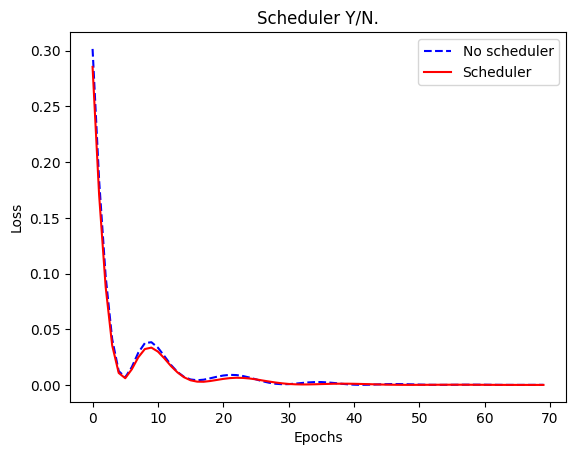

In [65]:
scope = 70
fig, ax = plt.subplots()


# Plot the second scatter plot with blue dots
ax.plot(range(scope), cache["no_scheduler"][:scope], linestyle='--',c='blue', label='No scheduler')

# Plot the first scatter plot with red dots
ax.plot(range(scope), cache["scheduler"][:scope], linestyle='-', c='red', label='Scheduler')



# Add labels and a legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Scheduler Y/N.')
ax.legend()

# Show the plot
plt.show()

tensor([1278])


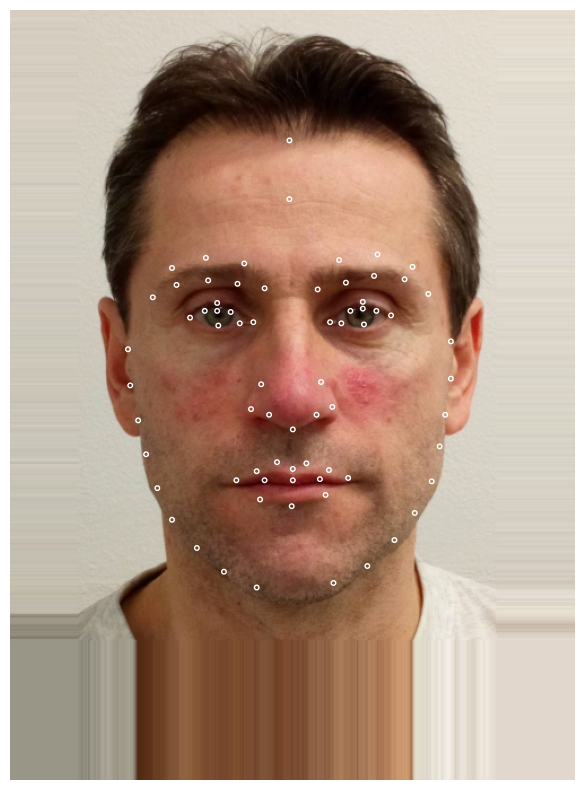

In [93]:
idx = torch.randint(face_dataset2.__len__(),(1,))
print(idx)
batch = face_dataset2.__getitem__(idx)
inputs, targets, centroid, size_measure, multicrop = batch
img_path = face_dataset2.path_list[idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
landmarks, _, image = model2.predict(image, face_detail=True)
display_landmarks(landmarks.reshape(-1,2), image, pixel_scale=True, origin='upper_left')
# display_landmarks(inputs.reshape(-1,2), image, pixel_scale=False, origin='upper_left')
# display_landmarks(targets.reshape(-1,2), image, pixel_scale=False, origin='upper_left')

In [9]:
group = sample_groups[np.random.randint(len(sample_groups))]
for file in os.listdir(group):
    if '.TPS' in file or '.tps' in file:
        tps = readtps(group + '/' + file, group)
        
idx = np.random.randint(len(tps['im']))
true_l= tps['coords'][:, :, idx]
img_path = group + '/' + tps['im'][idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
subimage, xmin, ymin, xmax, ymax = crop_face_only(image)
subimage = standard_face_size(subimage)
plt.imshow(subimage)

NameError: name 'sample_groups' is not defined

In [73]:
@torch.no_grad()
def show_some_results(group = None, idx = None):
    if group is None:
        group = sample_groups[np.random.randint(len(sample_groups))]
    
    for file in os.listdir(group):
        if '.TPS' in file or '.tps' in file:
             tps = readtps(group + '/' + file, group)
        
    if idx is None:
        idx = np.random.randint(len(tps['im']))
        
    true_landmarks = tps['coords'][:, :, idx]
    img_path = group + '/' + tps['im'][idx]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_detail = crop_face_only(image)
    if face_detail:
        subimage, xmin, ymin, xmax, ymax = face_detail
    
    # Both model use float(0,1) for x and y axis
    input_landmarks = MediaPipe_model(subimage)
    #input_landmarks = np.concatenate((LBF_model(image), MediaPipe_model(image)), axis = 0)

    #true_landmarks = np.subtract(true_landmarks, (xmin, image.shape[0] - ymax))
    #true_landmarks = np.divide(true_landmarks, (subimage.shape[1], subimage.shape[0]))
     
    # Převod původních pixelových na float, flip y-axis
    true_landmarks = torch.from_numpy(1 - np.divide(true_landmarks, (image.shape[1], image.shape[0]))).to(device)

    # batch_dim = 0
    input_landmarks = torch.from_numpy(input_landmarks.reshape(1,-1)).float().to(device)
    raw_landmarks, _ = model.raw_projection(input_landmarks, None)

    multicrop = make_landmark_crops(raw_landmarks, subimage)
    
    #předělat a použít prediction method
    projection, _, _ = model(input_landmarks, true_landmarks.reshape(1,-1), multicrop = multicrop[None,:,:,:], image_shape = subimage.shape)
    projection = projection.cpu().detach().numpy().reshape(true_landmarks.shape)
    
    # tady připočíst xmin a ten druhý pól image_shape - ymax
    return projection, image, true_landmarks, raw_landmarks

In [ ]:
model.eval()
idx = -1

In [ ]:
idx += 10

In [ ]:
proj, im, y, raw = show_some_results(idx)

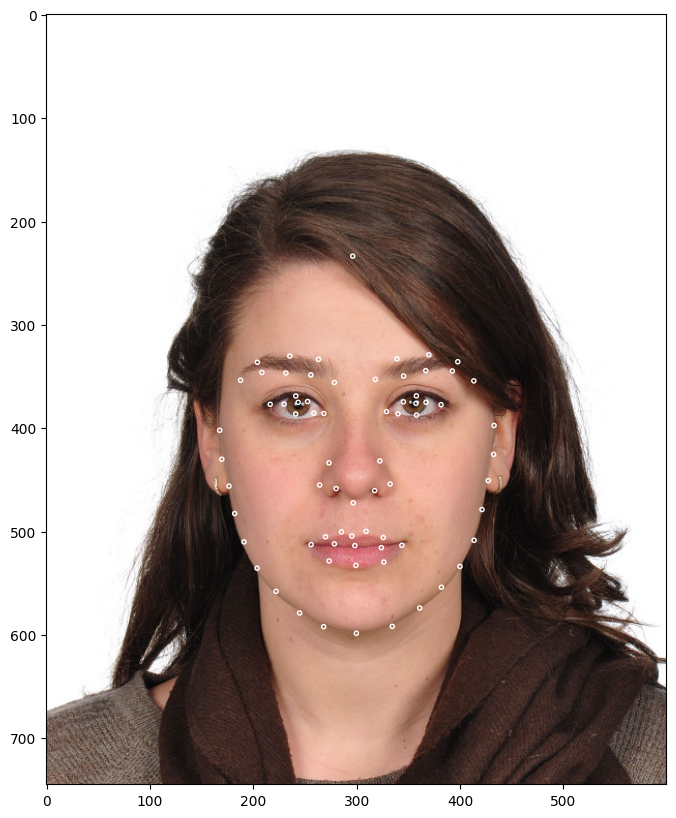

In [ ]:
display_landmarks(proj.reshape(-1,2), im, pixel_scale = False, origin = 'upper_left')